In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd

from scipy.special import expit
from ampligraph.latent_features import ComplEx, TransE, DistMult, HolE
from ampligraph.evaluation import generate_corruptions_for_fit, create_mappings, to_idx
from netcal.scaling import BetaCalibration 
from netcal.binning import IsotonicRegression, HistogramBinning
from netcal.metrics import ECE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
%matplotlib inline

In [2]:
def negative_sampling(dat, eta=1):
    '''
    Given a set of positive triples, perform negative sampling by corruption
    return a set of (X, y)
    '''
    rel_to_idx, ent_to_idx = create_mappings(dat)
    dat_id = to_idx(dat, ent_to_idx, rel_to_idx)
    dat2 = generate_corruptions_for_fit(dat_id, eta=eta)

    dat2_id = dat2.eval(session=tf.compat.v1.Session())
    X = np.concatenate([dat_id, dat2_id])
    y = np.concatenate([np.ones(len(dat_id)), np.zeros(len(dat2_id))])
    idx_to_rel = {v:k for k,v in rel_to_idx.items()}
    idx_to_ent = {v:k for k,v in ent_to_idx.items()}
    C = []
    for x in X:
        h, r, t = x
        C.append([idx_to_ent[h], idx_to_rel[r], idx_to_ent[t]])

    return np.array(C), y

def filter_unseen(train, test, y_test):
    entities = set()
    relations = set()
    for x in train:
        h, r, t = x
        entities.add(h)
        relations.add(r)
        entities.add(t)
    filtered_triple = []
    filtered_y = []
    for i in range(len(test)):
        h, r, t = test[i]
        if (h in entities) and (t in entities) and (r in relations):
            filtered_triple.append([h, r, t])
            filtered_y.append(y_test[i])
    return np.array(filtered_triple), np.array(filtered_y)



In [3]:
with open('ontology_log_instance.ttl', 'r') as f:
    lines = np.array([i.strip().split(' ')[:3] for i in f.readlines()])
    
dat = []
for l in lines:
    if str(l[2]).startswith('<http'):
        dat.append(l)
dat = np.array(dat)
np.random.shuffle(dat)

X_train = dat[:int(len(dat)*0.7)]
X_rest = dat[int(len(dat)*0.7):]

X, y = negative_sampling(X_rest, eta=1)
X_cal, X_test, y_cal, y_test = train_test_split(X, y)

X_cal, y_cal = filter_unseen(X_train, X_cal, y_cal)
X_test, y_test = filter_unseen(X_train, X_test, y_test)

print(X_cal, y_cal)

[['<http://treat.net/onto.owl#alm_100001_803>'
  '<http://treat.net/onto.owl#has_parameter>'
  '<http://treat.net/onto.owl#alarm_para_instance_1716>']
 ['<http://treat.net/onto.owl#alm_5521_836>'
  '<http://treat.net/onto.owl#has_parameter>'
  '<http://treat.net/onto.owl#alarm_para_instance_714>']
 ['<http://treat.net/onto.owl#alarm_para_instance_499>'
  '<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>'
  '<http://www.w3.org/2002/07/owl#NamedIndividual>']
 ...
 ['<http://treat.net/onto.owl#alarm_para_instance_580>'
  '<http://treat.net/onto.owl#instance_of>'
  '<http://treat.net/onto.owl#alarm_para_instance_3073>']
 ['<http://treat.net/onto.owl#alarm_para_instance_2485>'
  '<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>'
  '<http://treat.net/onto.owl#alm_100155_53>']
 ['<http://treat.net/onto.owl#alarm_para_instance_695>'
  '<http://treat.net/onto.owl#alarm_source>'
  '<http://treat.net/onto.owl#alarm_para_instance_1376>']] [1. 1. 1. ... 0. 0. 0.]


In [4]:
model = TransE(verbose=True)
model.fit(X_train)

Average TransE Loss:   1.107205: 100%|████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30epoch/s]


In [14]:
def cal_and_eval(model, calibrator, X_cal, y_cal, X_test, y_test):
    scores_cal = expit(model.predict(X_cal))    
    calibrator.fit(scores_cal, y_cal)
    scores_test = expit(model.predict(X_test))
    proba_test = calibrator.transform(scores_test)
    print('MES:', mean_squared_error(proba_test, y_test))
    ece = ECE()
    print('ECE:', ece.measure(proba_test, y_test))
    return proba_test


calibrator = BetaCalibration()
probs = cal_and_eval(model, calibrator, X_cal, y_cal, X_test, y_test)
prob_triples = np.c_[(X_test, probs)]
df = pd.DataFrame(prob_triples,columns=['head', 'relation', 'tail', 'proba'])
df

MES: 0.11837956135202506
ECE: 0.05102247271931624


,head,relation,tail,proba
0,<http://treat.net/onto.owl#alm_5521_859>,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://treat.net/onto.owl#Alarm>,0.078516155
1,<http://treat.net/onto.owl#alm_100058_15619>,<http://treat.net/onto.owl#has_parameter>,<http://treat.net/onto.owl#alarm_para_instance...,0.8812648
2,<http://treat.net/onto.owl#alm_221257768_16111>,<http://treat.net/onto.owl#instance_of>,<http://treat.net/onto.owl#alm_221257768>,0.86594087
3,<http://treat.net/onto.owl#alm_100058_15774>,<http://treat.net/onto.owl#has_parameter>,<http://treat.net/onto.owl#alarm_para_instance...,0.8902612
4,<http://treat.net/onto.owl#alarm_para_instance...,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://www.w3.org/2002/07/owl#NamedIndividual>,0.71699065
...,...,...,...,...
5250,<http://treat.net/onto.owl#alm_para_282>,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://www.w3.org/2002/07/owl#NamedIndividual>,0.25806552
5251,<http://treat.net/onto.owl#alarm_para_instance...,<http://treat.net/onto.owl#has_parameter>,<http://treat.net/onto.owl#alarm_para_instance...,0.08886055
5252,<http://treat.net/onto.owl#alarm_para_instance...,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://treat.net/onto.owl#Alarm_Para_Instance>,0.7573476
5253,<http://treat.net/onto.owl#alm_5521_892>,<http://treat.net/onto.owl#has_parameter>,<http://treat.net/onto.owl#alarm_para_instance...,0.83217865


<AxesSubplot:>

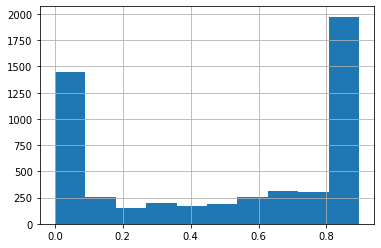

In [15]:
df['proba'].astype(float).hist()

In [119]:
prob_triples

array([['<http://treat.net/onto.owl#alm_5521_859>',
        '<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>',
        '<http://treat.net/onto.owl#Alarm>', '0.078516155'],
       ['<http://treat.net/onto.owl#alm_100058_15619>',
        '<http://treat.net/onto.owl#has_parameter>',
        '<http://treat.net/onto.owl#alarm_para_instance_2172>',
        '0.8812648'],
       ['<http://treat.net/onto.owl#alm_221257768_16111>',
        '<http://treat.net/onto.owl#instance_of>',
        '<http://treat.net/onto.owl#alm_221257768>', '0.86594087'],
       ...,
       ['<http://treat.net/onto.owl#alarm_para_instance_93>',
        '<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>',
        '<http://treat.net/onto.owl#Alarm_Para_Instance>', '0.7573476'],
       ['<http://treat.net/onto.owl#alm_5521_892>',
        '<http://treat.net/onto.owl#has_parameter>',
        '<http://treat.net/onto.owl#alarm_para_instance_1349>',
        '0.83217865'],
       ['<http://treat.net/onto.owl#alarm_para_instan

In [115]:
entities = set()
relations = set()
for x in X_train:
    h, r, t = x
    entities.add(h)
    relations.add(r)
    entities.add(t)

import random
from pprint import pprint
prob = 0
while prob < 0.5:
    h = random.sample(entities,1)[0]
    r = random.sample(relations, 1)[0]
    t = random.sample(entities, 1)[0]
    score = model.predict([h,r,t])
    prob = calibrator.transform(expit(score)).round(3)
    pprint([h, r, t])
    print(prob)


['<http://treat.net/onto.owl#alarm_para_instance_566>',
 '<http://treat.net/onto.owl#sbi_mapping>',
 '<http://treat.net/onto.owl#alarm_para_instance_1055>']
0.815


In [134]:
class Triple:
    def __init__(self, subj, pred, obj, mu=None, v=None):
        self.subj = subj
        self.pred = pred
        self.obj = obj
        self._beta_a = 0
        self._beta_b = 0
        if mu != None and v != None:
            self._calculate_beta_mu_v(mu, v)
    def __str__(self):
        return f'{self.prob}::({self.subj}, {self.pred}, {self.obj})'
    def __repr__(self):
        return self.__str__()
    def _calculate_beta_mu_v(self, mu, v):
        '''calculate a and b of beta distribution by mean and sample size'''
        self._beta_a = mu * v
        self._beta_b = (1 - mu) * v
        return self._beta_a, self._beta_b
    @property
    def prob(self):
        return self._beta_a / (self._beta_a + self._beta_b)
    def assign_init_prob_mu_v(self, mu, v):
        _calculate_beta_mu_v(mu, v)
    def update_beta_a_b(self, evds_stream):
        num_ones = list(evds_stream).count(1)
        num_zeros = list(evds_stream).count(0)
        self._beta_a += num_ones
        self._beta_b += num_zeros
        return self._beta_a, self._beta_b
    
    
def make_synthetic_evidence(triples):
    evds = []
    for t in triples:
        num_evd = random.randint(0,100)
        evds.append(np.random.randint(2, size=num_evd))
    return evds

def assign_init_probs(triples):
    return

def update_probas(p_triples, evds):
    return



In [143]:
evds = make_synthetic_evidence(prob_triples)

In [140]:
trps = []
for i in prob_triples:
    trps.append(Triple(i[0], i[1], i[2], float(i[3]), 10))
print(trps[0])

0.078516155::(<http://treat.net/onto.owl#alm_5521_859>, <http://www.w3.org/1999/02/22-rdf-syntax-ns#type>, <http://treat.net/onto.owl#Alarm>)


In [155]:
for i in range(len(trps)):
    trps[i].update_beta_a_b(evds[i])

In [158]:
trps[0]

0.38469625152284265::(<http://treat.net/onto.owl#alm_5521_859>, <http://www.w3.org/1999/02/22-rdf-syntax-ns#type>, <http://treat.net/onto.owl#Alarm>)